# Using numerical and categorical variables together

How to combine the preprocessing steps to treat numerical and categorical variables?.

Load the entire adult census dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('adult_cencus.csv')

#### **Dealing with missing values**

In [3]:
df.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     857
class                0
dtype: int64

In [5]:
df[['workclass', 'occupation', 'native_country']].dtypes

workclass         object
occupation        object
native_country    object
dtype: object

All missing values are in categorical features, so i choose to fill them with **'unknown'**.

In [6]:
df[['workclass', 'occupation', 'native_country']].fillna('Unknown', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Before continuing the processing steps, since education and education_num features gives the same information, ill keep just one of them, so education will be removed from the dataset

In [7]:
data, target = df.drop(columns=['education', 'class']), df['class']

### **Separate categorical and numerical features**

In [8]:
from sklearn.compose import make_column_selector as selector

numerical = selector(dtype_include=np.number)(data)
categorical = selector(dtype_include=object)(data)

Now the dataset is ready to be preprocessed

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education_num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital_gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital_loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours_per_week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


I note that the numerical features need to be scaled, since their averages are very different.

## Dispatch columns to a specific processor

I know that I need to treat data differently depending on their nature (i.e. numerical or categorical).

Scikit-learn provides a `ColumnTransformer` class which will send specific
columns to a specific transformer, making it easy to fit a single predictive model on a dataset that combines both kinds of variables together (heterogeneously typed tabular data).

We first define the columns depending on their data type:

* **one-hot encoding** will be applied to categorical columns. Besides, we
  use `handle_unknown="ignore"` to solve the potential issues due to rare
  categories.
* **numerical scaling** numerical features which will be standardized.

`ColumnTransfomer` preprocessor contains three values:
- the preprocessor name, 
- the transformer, 
- and the columns.

First, let's create the preprocessors for the numerical and categorical
parts.

In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore')

Now, I create the transformer and associate each of these preprocessors
with their respective columns.

In [13]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num_scaler', scaler, numerical),
    ('onehot', encoder, categorical),
])

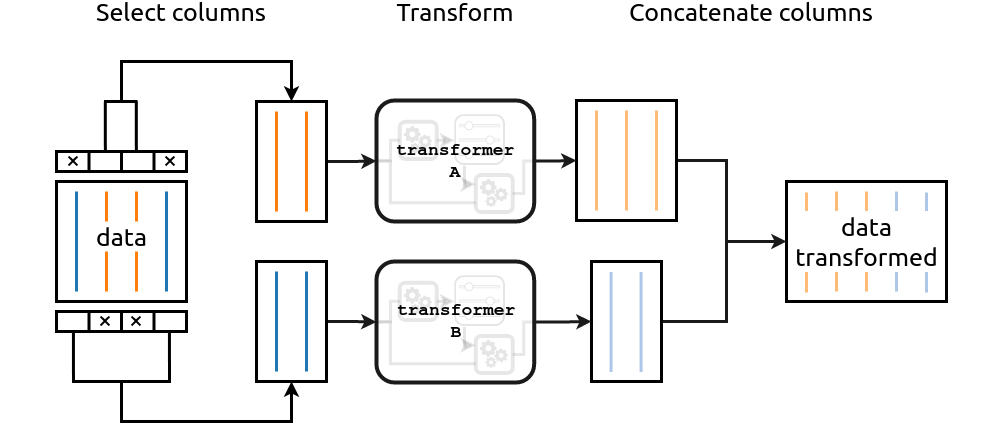

A `ColumnTransformer` does the following:

* It **splits the columns** of the original dataset based on the column names
  or indices provided. We will obtain as many subsets as the number of
  transformers passed into the `ColumnTransformer`.
* It **transforms each subsets**. A specific transformer is applied to
  each subset: it will internally call `fit_transform` or `transform`. The
  output of this step is a set of transformed datasets.
* It then **concatenates the transformed datasets** into a single dataset.

The important thing is that `ColumnTransformer` is like any other
scikit-learn transformer. In particular it can be combined with a classifier
in a `Pipeline`:

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000)
)

Displaying an interactive diagram 

In [15]:
from sklearn import set_config
set_config(display='diagram')
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])